# Lowman Coherence

This is the start of my exploration of what coherence looks like for the Lowman site in Idaho. 

In [2]:
from pathlib import Path
from datetime import datetime
from time import time

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import tifffile as tif

from uavsar_pytools.convert.tiff_conversion import read_annotation

/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import my custom modules. 
I had to import specific functions from my files, otherwise I was getting an error. 

In [3]:
import sys
import os

scripts_dir = (os.path.dirname(os.getcwd()) + '/scripts/')
sys.path.append(scripts_dir)

from plotting import plot_tifs_grid 
from coherence import calc_coherence_unweighted

In [4]:
data_dir = "../data/data/snowex_lowman/slcs/"
in_dir = Path(data_dir)
slcs_05208 = sorted(list(in_dir.glob('*05208*.slc')))
anns_05208 = sorted(list(in_dir.glob('*05208*.ann')))
slcs_23205 = sorted(list(in_dir.glob('*23205*.slc')))
anns_23205 = sorted(list(in_dir.glob('*23205*.ann')))

In [4]:
d5 = read_annotation(anns_05208[0])
d5 = pd.DataFrame(d5).T
rows, cols = d5.loc['slc_2_2x8 rows', 'value'], d5.loc['slc_2_2x8 columns', 'value']
stack5 = np.zeros((len(slcs_05208), rows, cols), '<c8')
dates5 = []
for i, (slc, ann) in enumerate(zip(slcs_05208, anns_05208, strict = True)):
    print(slc)
    d = read_annotation(ann)
    d = pd.DataFrame(d).T
    timestamp = d.loc['start time of acquisition', 'value']

    
    stack5[i, :, :] = np.fromfile(slc, '<c8').reshape(rows, cols)
    dates5.append(timestamp)

../data/data/snowex_lowman/slcs/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_20011_002_200221_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_20016_003_200311_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8.slc


In [5]:
d2 = read_annotation(anns_23205[0])
d2 = pd.DataFrame(d2).T
rows, cols = d2.loc['slc_2_2x8 rows', 'value'], d2.loc['slc_2_2x8 columns', 'value']
stack2 = np.zeros((len(slcs_23205), rows, cols), '<c8')
dates2 = []
for i, (slc, ann) in enumerate(zip(slcs_23205, anns_23205, strict = True)):
    print(slc)
    d = read_annotation(ann)
    d = pd.DataFrame(d).T
    timestamp = d.loc['start time of acquisition', 'value']

    
    stack2[i, :, :] = np.fromfile(slc, '<c8').reshape(rows, cols)
    dates2.append(timestamp)

../data/data/snowex_lowman/slcs/lowman_23205_20002_007_200131_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_20007_003_200213_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_20011_003_200221_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_20016_004_200311_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21002_004_210115_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21004_003_210120_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21008_000_210127_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21009_004_210203_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21012_000_210210_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21015_008_210303_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21017_018_210310_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21019_018

In [7]:
print(len(stack5))

10


Calculaing the coherence in a loop for the 10 lowman 05208 files took 30 seconds per pair for 45 total pair combinations. After doing this once, I saved all of those output into one big .tif file with 45 layers. 

This file is 14 GB but loads pretty quickly using the tifffile module. 

In [5]:
c5 = []
# for i in range(len(stack5)) : 
#     for j in range(len(stack5)) : 
#         if (i >= j) : 
#             continue
#         start_time = time()
#         print(f"calculating coherence for img {i} and img {j}")
#         c5.append(calc_coherence_unweighted(stack5[i], stack5[j]))
#         end_time = time()
#         elapsed_time = end_time - start_time
#         print(f"   elapsed time: {elapsed_time} seconds")

### OR 
c5 = tif.imread(data_dir + 'lowman_05208_coherences.stack')

In [6]:
print(c5.shape)
# tif.imwrite(data_dir + 'lowman_05208_coherences.stack', c5, bigtiff=True)
# c5.tofile(data_dir + '../lowman_05208_coherences.stack')

(45, 8333, 4896)


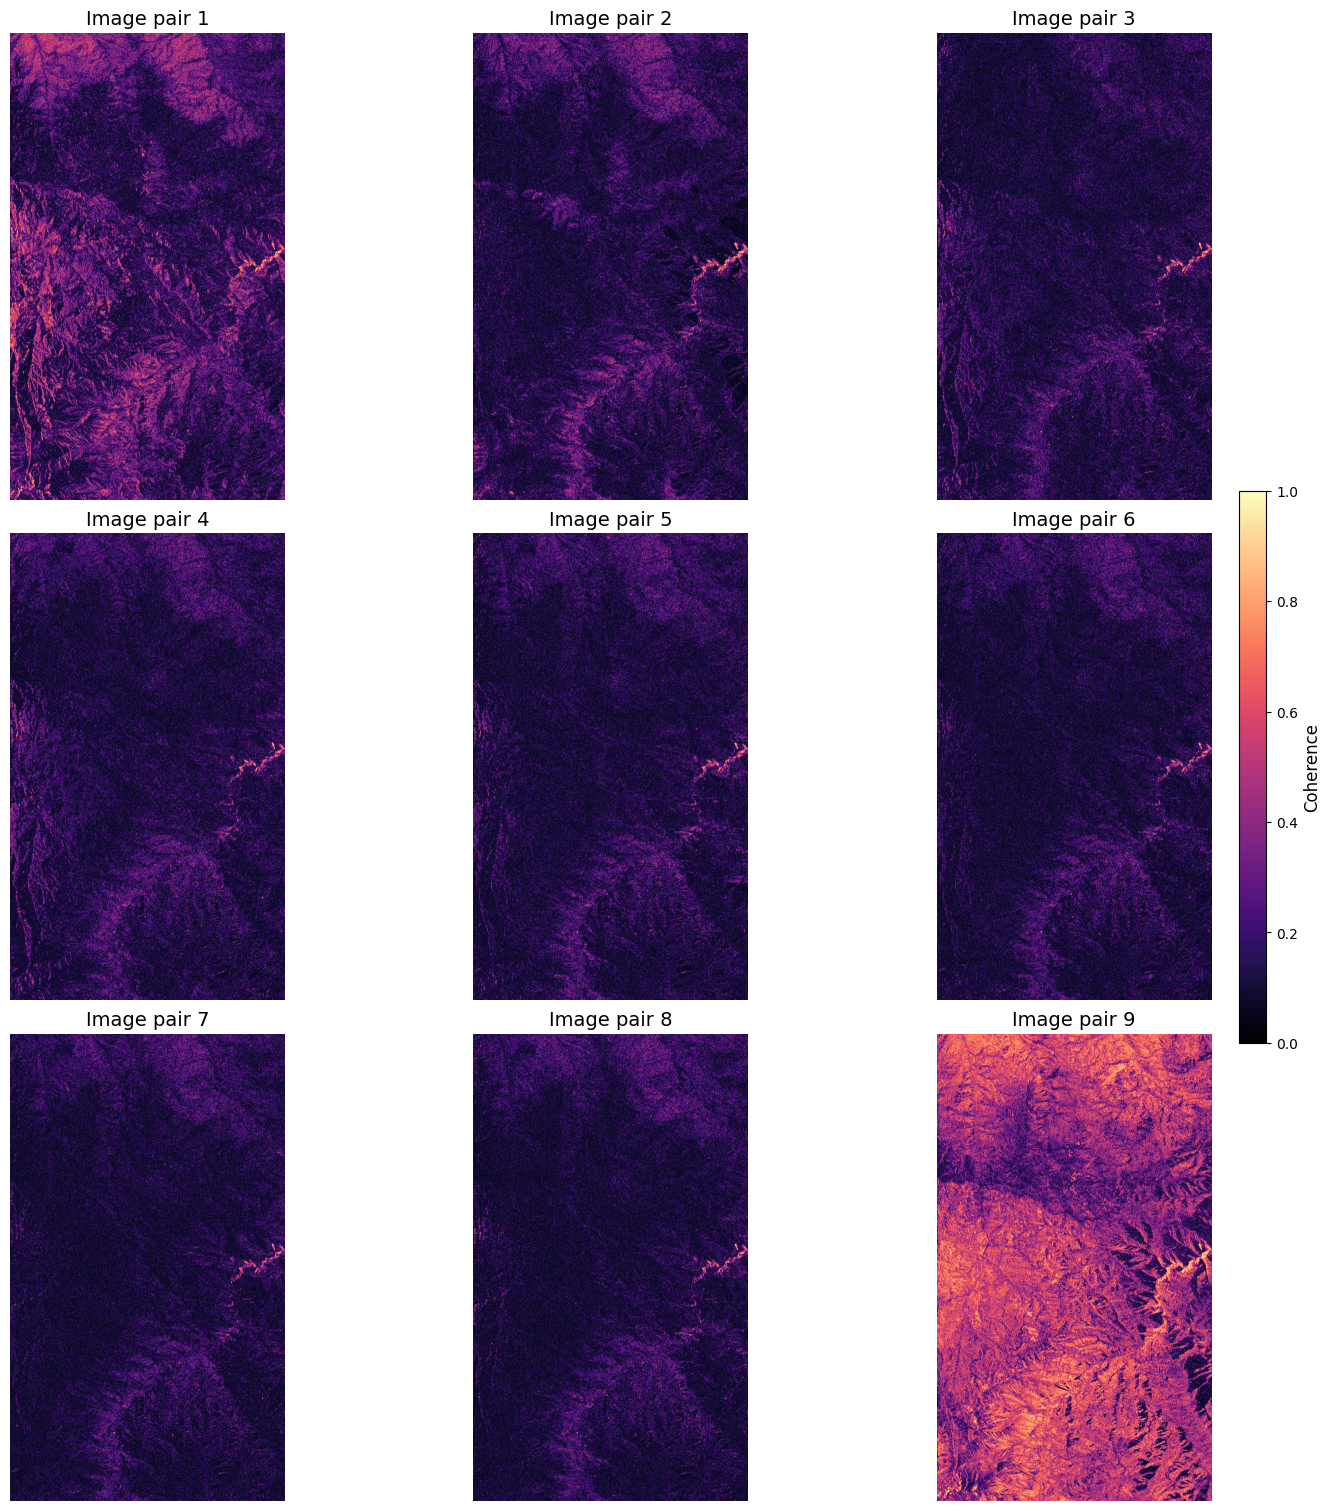

In [8]:
plot_tifs_grid(c5[1:10, :, :], is_file=False)

At this stage, I should have a stack of coherences between every image pair. For all 10 images, this will be 

Next I want to calculate average coherence for each image pair and make it into a coherence matrix, like Zach suggests. 

Then I want to 